<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">1. INTRODUCTION</div>

This notebooks is to apply AutoEncoderDecoder in solving Dimensionality Reduction

 ## <font color=red>**Stacked AutoEncoder**</font>
 
 ###  <font color=blue>Introduction</font>
 
1.	An auto-encoder is a kind of intersection between supervised and unsupervised learning that is commonly used for dimensionality reduction and feature discovery. More precisely, an auto-encoder is a feedforward neural network that is trained to predict the input itself. 


2. To prevent the system from learning the trivial identity mapping, the hidden layer in the middle is usually constrained to be a narrow bottleneck. The system can minimize the reconstruction error by ensuring the hidden units capture the most relevant aspects of the data which can be considered as the lower representation of data

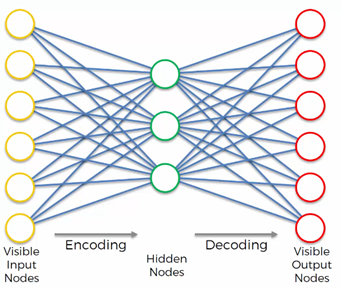


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">2. SETUP</div>

 ## <font color=red>2.1. Import library</font>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import sklearn.decomposition as dec
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Common imports
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os


## for processing text data
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import string
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.corpus import stopwords

# for calculating similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import  LabelEncoder

# for classification
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for word embedding
import gensim
import gensim.downloader as gensim_api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# to make this notebook's output stable across runs
np.random.seed(42)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
# import seaborn to make nice plots
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

C:\Users\Mai\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 ## <font color=red>2.2. Utitlity functions</font>

In [2]:
def plot_cluster(X, y):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    ax[0].scatter(X[:,0], X[:,1], s=5)
    ax[1].scatter(X[:,0], X[:,1], c=y, s=5, cmap='jet')
    plt.axis("off")
    plt.show()
    
    
def plot_data(X, y, n_cluster):
    palette = np.array(sns.color_palette("hls", n_cluster))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sc = ax.scatter(X[:,0], X[:,1], s=3,c=y, cmap="jet")
    # We add the labels for each digit.
    txts = []
    for i in range(n_cluster):
        # Position of each label.
        xtext, ytext = np.median(X[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
                PathEffects.Stroke(linewidth=3, foreground="w"),
                PathEffects.Normal()])
        txts.append(txt)    
        
        
def compare_truelabel_cluster(X, y, cluster):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    ax[0].scatter(X[:,0], X[:,1], s=3, c=y, cmap='jet')
    ax[1].scatter(X[:,0], X[:,1], s=3, c=cluster, cmap='jet')
    plt.axis('off')
    plt.show()
    
    
def show_image(images, n_images=5):
    nrows, ncols = 1, 5
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    plt.gray()
    for i in range(ncols * nrows):
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(images.reshape(len(images),28,28)[i])
        plt.xticks([])
        plt.yticks([])    
            
    plt.show()    

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">3. IMAGE DATA - MNISTS DATASET</div>

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set

the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

 ## <font color=red>3.1. Data Preparation</font>

 ### <font color=blue>**Full dataset**

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.dtype)
print(X_train_full.shape, X_test.shape)

uint8
(60000, 28, 28) (10000, 28, 28)


 ### <font color=blue>**User a part of full dataset to reduce the training time**

In [ ]:
X_valid, X_train = X_train_full[:5000], X_train_full[45000:]
y_valid, y_train = y_train_full[:5000], y_train_full[45000:]
X_test = X_test
X_train.shape, X_valid.shape, X_test.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train_full = X_train_full.reshape(-1,784)
X_test = X_test.reshape(-1,784)

scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full.astype(np.float32))
X_test = scaler.transform(X_test.astype(np.float32))
#X_train_full = X_train_full.astype(np.float32) / 255
#X_test = X_test.astype(np.float32) / 255

X_train_full.shape, X_test.shape

In [ ]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train.shape, X_valid.shape, X_test.shape

 # <font color=red>3.2. AutoEncoder</font>

 ### <font color=blue>**Import libraries**

In [ ]:
# Deep Learnign libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.display import display, Math, Latex
import datetime

 ### <font color=blue>**Construct Model**

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each layer []
input_dim = X_train.shape[1]
encoding1_dim = 100
encoding2_dim = 500
latent_dim = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
encoder = Dense(int(latent_dim), activation='relu')(encoder)
decoder = Dense(int(encoding2_dim), activation='relu')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each layer []
input_dim = X_train.shape[1]
encoding1_dim = 350
encoding2_dim = 150
latent_dim = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
encoder = Dense(int(latent_dim), activation='relu')(encoder)
decoder = Dense(int(encoding2_dim), activation='relu')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

In [ ]:
# this models maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

 ### <font color=blue>**Training model**

In [ ]:
nb_epoch = 20
batch_size = 10
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_data=(X_valid, X_valid),
                          #verbose=1,
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

In [ ]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

 ### <font color=blue>**Visualize Result**

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_valid_ae = encoder_layer.predict(X_valid)
X_valid_ae_tsne = tsne.fit_transform(X_valid_ae)

tsne = TSNE()
X_valid_tsne = tsne.fit_transform(X_valid)

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_tsne[:, 0], X_valid_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
plt.show()

 ### <font color=blue>**Apply Clustering to embedded features**

In [ ]:
cluster_df = pd.DataFrame(y_valid, columns=['Label'])
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=9)
kmeans.fit(X_valid_ae_tsne)
cluster_labels = kmeans.labels_
cluster_df['KMeans_cluster'] = cluster_labels

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=cluster_df ['Label'], s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_ae_tsne[:, 0], X_valid_ae_tsne[:, 1], c=cluster_df ['KMeans_cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

In [ ]:
plot_data(X_valid_ae_tsne, y_valid, 10)

In [ ]:
plot_data(X_valid_ae_tsne, cluster_df ['KMeans_cluster'], 10)

 # <font color=red>3.3. Variational AutoEncoder</font>

 ### <font color=blue>**Cost function**

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
        
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

 ### <font color=blue>**Train model**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 20

inputs = keras.layers.Input(shape=[784])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(300, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(300, activation="selu")(x)
x = keras.layers.Dense(784, activation="selu")(x)
outputs = keras.layers.Reshape([784])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="adam")
history = variational_ae.fit(X_train, X_train, epochs=20, #batch_size=5000,
                             validation_data=(X_valid, X_valid))
df_history = pd.DataFrame(history.history)

In [ ]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_valid_vae = variational_encoder.predict(X_valid)[0]
X_valid_vae_tsne = tsne.fit_transform(X_valid_vae)

tsne = TSNE()
#X_valid_tsne = tsne.fit_transform(X_valid)

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_tsne[:, 0], X_valid_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=y_valid, s=5, cmap="jet")
plt.axis("off")
plt.show()

In [ ]:
cluster_df = pd.DataFrame(y_valid, columns=['Label'])
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=9)
kmeans.fit(X_valid_vae_tsne)
cluster_labels = kmeans.labels_
cluster_df['KMeans_cluster'] = cluster_labels

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=cluster_df ['Label'], s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_valid_vae_tsne[:, 0], X_valid_vae_tsne[:, 1], c=cluster_df ['KMeans_cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">4. TEXT DATA - NEWS CATEGORY</div>

The dataset used is “News category dataset” from Kaggle (https://www.kaggle.com/rmisra/news-category-dataset). This dataset is around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. The original dataset contains over 30 categories, but for the purposes of this analysis, I will work with a subset of 4: TRAVEL, FOOD & DRINK, BUSINESS, SPORTS

 
 The following steps are applied for converting text data to numeric features:
 
 + Detect language and filter only English
 + Normalize text
 + Split data into train set and test set
 + Feature Extraction using word embedding with Word2Vec model
 + Scaling independent features
 + Convert target from categorical data to numeric data

 # <font color=red>4.1. Data Preparation</font>

### <font color=blue>Import data</font>

In [ ]:
df = pd.read_csv('data/News_Category.csv')
print(df.shape)
## print 5 random rows
df = df.reset_index(drop=True)
df.head(5)

Column 'text' is the concatenation of column 'headline' and 'short_description'. The analysis use column 'text'  to cluster data

View column text in the first five rows

In [ ]:
for i in range(0,5):
    print(df.text[i])
    print('\n')

### <font color=blue>Detect Language</font>

In [ ]:
import langdetect

txt = df["text"].iloc[0]
df["text"] = df["text"].astype(str)
df['lang'] = df["text"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
df = df[df["lang"]=="en"]
df.shape

### <font color=blue>Normalizing text</font>

In [ ]:
def normalize_text(text, flg_stemm=False, flg_lemm=False, lst_stopwords=None):
    
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Removing Special Characters
    text = re.sub('[^a-zA-Z\s]', '', text)
    # non_ascii
    # text = "".join(i for i in s if ord(i)<128)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df["text"].apply(lambda x: normalize_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=lst_stopwords))

df.head()

In [ ]:
df.shape

### <font color=blue>Split dataset to train and test set</font>

In [ ]:
## split dataset
df.rename(columns={'category':'y'}, inplace=True)
df_train, df_test = model_selection.train_test_split(df, test_size=0.1, random_state=9)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
## get target
y_train = df_train["y"].values
y_test = df_test["y"].values

In [ ]:
df_train.head()

In [ ]:
df_test.head()

#### Inspect unique values of y

In [ ]:
df_train.y.value_counts()

It can be seen that news are divided into 4 categories represent 4 different topics need to be discovered using clustering techniques

### <font color=blue>Word Vectorization using Google's Word2vec Pretrained Word Embedding</font>

This part employes the Word2vec model which was released by Google in 2013 and trained on the Google News dataset (about 100 billion words). It uses a neural network based implementation with architectures like continuous Bag of Words and Skip-Grams to learn the distributed vector representation of words in a corpus

#### create a corpus of word for both train set  and test set

In [ ]:
wpt = nltk.WordPunctTokenizer()
train_corpus = [wpt.tokenize(document) for document in df_train['text_clean']]
test_corpus = [wpt.tokenize(document) for document in df_test['text_clean']]

In [ ]:
from gensim.models import word2vec
EMBEDDING_FILE = r'C:\Users\Mai\OneDrive\02-PProjects\DataAnalyticsApp\notebook\GoogleNews-vectors-negative300.bin.gz'

# Set values for various parameters
feature_size = 300    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)
pretrained_model.train(tokenized_corpus, total_examples=pretrained_model.corpus_count, epochs=5)

In [96]:
pretrained_model.similarity('train','cat'),pretrained_model.similarity('train','travel'),  pretrained_model.similarity('dog','cat')

<ipython-input-96-ae79fca1743f>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  pretrained_model.similarity('train','cat'),pretrained_model.similarity('train','travel'),  pretrained_model.similarity('dog','cat')


(0.08540114, 0.29063696, 0.76094574)

In [97]:
def vectorize(corpus, model):
    # global embeddings
    embeddings = []
    for line in corpus:
        w2v = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if w2v is None:
                    w2v = model.wv[word]
                else:
                    w2v = w2v + pretrained_model.wv[word]
        if w2v is not None:
            w2v = w2v / count
            # append element to the end of the embeddings list
            embeddings.append(w2v)
        
    return embeddings

In [98]:
embeddings = vectorize(df_train['text_clean'], pretrained_model)
X_train = pd.DataFrame(embeddings)
print(X_train.shape)
X_train.head()

(22401, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.013387,0.002963,-0.072313,0.049958,0.073772,-0.052404,0.077160,-0.189556,0.161333,0.103191,...,0.037663,-0.069709,-0.068263,0.046233,0.082772,-0.019301,-0.058505,-0.036242,0.009148,-0.081307
1,-0.057078,0.054952,-0.018173,0.090713,-0.015724,-0.028263,0.036750,-0.026626,0.061599,0.081586,...,0.014614,0.001357,-0.040587,0.019176,-0.027613,-0.053956,-0.048696,0.010084,0.071327,-0.021087
2,0.098176,-0.008665,0.062386,-0.071269,0.007409,-0.014413,0.030065,-0.067311,0.101806,0.105662,...,-0.041317,-0.030924,-0.087253,0.035466,-0.022012,-0.019490,-0.001523,-0.034358,-0.053358,-0.023206
3,0.014390,0.046662,0.044546,0.008773,-0.039424,-0.008084,0.022649,-0.051144,0.151741,0.077339,...,0.051671,0.051920,-0.050126,0.073308,0.021059,-0.020212,-0.067785,-0.084532,-0.034895,0.063425
4,-0.030037,0.061885,-0.026994,0.087945,-0.032175,0.034307,0.007106,-0.061879,-0.007891,0.056373,...,0.032639,-0.005960,-0.105052,-0.030077,0.015946,-0.031099,-0.017467,-0.064718,-0.004793,0.004838


### <font color=blue>Scaling data</font>

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = range(0, 300))

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.501085,0.355751,0.265850,0.344910,0.735338,0.372531,0.654610,0.280810,0.776435,0.514003,...,0.581615,0.336694,0.545142,0.589072,0.610438,0.613281,0.388854,0.498497,0.415300,0.205773
1,0.320902,0.487113,0.396923,0.431207,0.512300,0.431357,0.543682,0.670354,0.572876,0.470355,...,0.525147,0.509127,0.606750,0.527973,0.398379,0.523098,0.408639,0.600509,0.568988,0.363259
2,0.717891,0.326369,0.591959,0.088225,0.569953,0.465108,0.525331,0.573081,0.654939,0.518995,...,0.388125,0.430801,0.502868,0.564757,0.409140,0.612790,0.503789,0.502646,0.260805,0.357716
3,0.503648,0.466167,0.548770,0.257706,0.453237,0.480531,0.504972,0.611734,0.756858,0.461775,...,0.615933,0.631814,0.585516,0.650211,0.491883,0.610910,0.370136,0.392159,0.306441,0.584275
4,0.390048,0.504632,0.375567,0.425346,0.471302,0.583830,0.462307,0.586067,0.431043,0.419417,...,0.569306,0.491374,0.463247,0.416753,0.482060,0.582580,0.471629,0.435792,0.380842,0.431059


In [100]:
X_train.shape

(22401, 300)

### <font color=blue>Convert target from category to numeric data</font>

In [101]:
target_value_mapping = {'TRAVEL':0, 'FOOD & DRINK':1, 'BUSINESS':2, 'SPORTS':3}
y_train = df_train['y'].map(target_value_mapping)
y_test = df_test['y'].map(target_value_mapping)

In [102]:
# Deep Learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers  import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
# deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime

In [103]:
tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()

# No of neurons in each layer
input_dim = X_train.shape[1]
encoding1_dim = 80
encoding2_dim = 600
latent_dim = 18

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation="relu")(encoder)
encoder = Dense(int(latent_dim), activation="tanh")(encoder)
decoder = Dense(int(encoding2_dim), activation="tanh")(encoder)
decoder = Dense(int(encoding1_dim), activation="relu")(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 80)                24080     
                                                                 
 dense_1 (Dense)             (None, 600)               48600     
                                                                 
 dense_2 (Dense)             (None, 18)                10818     
                                                                 
 dense_3 (Dense)             (None, 600)               11400     
                                                                 
 dense_4 (Dense)             (None, 80)                48080     
                                                                 
 dense_5 (Dense)             (None, 300)               24300 

In [104]:
# this model maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

In [105]:
nb_epoch = 30
batch_size = 10
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_split=0.2, 
                          verbose=1
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0931 - val_loss: 0.0882
Epoch 2/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0831 - val_loss: 0.0804
Epoch 3/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0752 - val_loss: 0.0697
Epoch 4/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0612 - val_loss: 0.0504
Epoch 5/30
560/560 [==============================] - 2s 4ms/step - loss: 0.0388 - val_loss: 0.0324
Epoch 6/30
560/560 [==============================] - 2s 4ms/step - loss: 0.0299 - val_loss: 0.0267
Epoch 7/30
560/560 [==============================] - 3s 6ms/step - loss: 0.0243 - val_loss: 0.0229
Epoch 8/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0219 - val_loss: 0.0201
Epoch 9/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0184 - val_loss: 0.0176
Epoch 10/30
560/560 [==============================] - 3s 5ms/step - loss: 0.0165 - val_loss: 0.0153

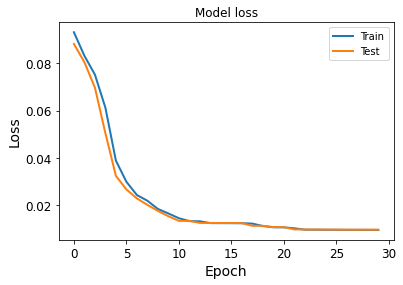

In [106]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [107]:
encoded = encoder_layer.predict(X_train)
ae_embeddings = pd.DataFrame(encoded)
print(ae_embeddings.shape)
ae_embeddings.head()

(22401, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.051318,0.058925,0.003626,0.222324,-0.083676,-0.101887,-0.007911,-0.074319,-0.087322,-0.080369,0.160663,0.251937,0.177706,-0.019564,-0.321176,-0.199542,-0.117853,0.613659
1,-0.011914,0.122576,-0.113854,0.080557,-0.106427,0.118920,0.007737,-0.075831,-0.137313,-0.015010,-0.042202,-0.051510,-0.149779,-0.035712,-0.008459,0.004677,-0.156422,0.609315
2,-0.060204,0.061088,-0.145211,0.020163,-0.105850,-0.086453,-0.013164,0.031623,0.027276,0.137704,0.194235,0.083962,0.127544,-0.047850,-0.145171,-0.159155,0.142750,0.621015
3,-0.127849,-0.115094,-0.108595,0.023725,0.075867,-0.281572,0.210955,-0.010311,0.218723,-0.001604,0.045984,-0.035038,0.101836,0.005811,-0.315688,0.047710,-0.014766,0.465683
4,0.010488,0.000447,0.021668,0.055301,-0.134979,0.085005,0.108694,-0.132601,-0.233468,0.005779,0.096452,-0.068976,0.033416,0.053033,-0.001083,0.166533,-0.088302,0.616505


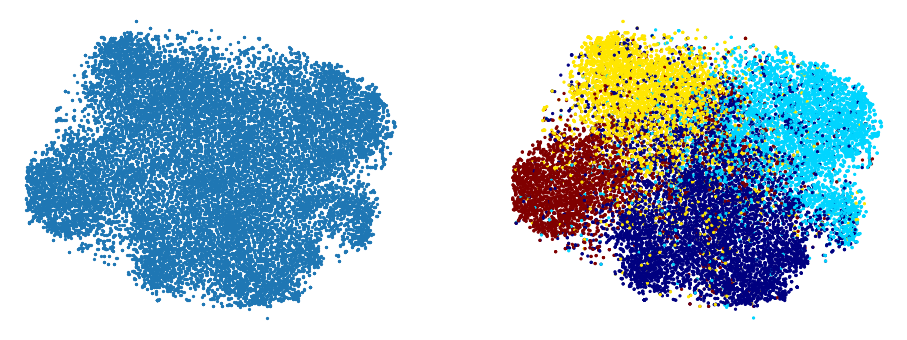

In [108]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=9)
X_train_tsne = tsne.fit_transform(ae_embeddings)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=5)
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
plt.show()

=> The fig on the left is the shape/pattern of data after being compressed using PCA and T-SNE, and the fig on the right hand side is the underlying topic/class of the data

=> Assuming that we don't have label (hence the fig on the right hand side is not available), it can be seen on the left fig that the plot suggests there are around 4 clusters, 1 cluster at the top, and 2 clusters at middle, 1 cluster at the bottom

In [109]:
from sklearn.cluster import KMeans
from scipy import stats

def specify_num_of_clusters(data, n_clusters):
    wcss = []
    for i in range(1, n_clusters):
        kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
    plt.plot(range(1,11), wcss)
    plt.title('Elbow Method')
    plt.xlabel("K Clusters")
    plt.ylabel("WCSS")
    plt.show()
    
    

def mapping_cluster_class(y, cluster):
    mapping = {}
    for class_id in np.unique(y):
        mode, _ = stats.mode(cluster[y==class_id])
        print(mode)
        mapping[mode[0]] = class_id
    return mapping

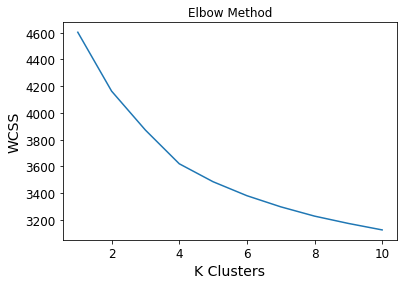

In [110]:
specify_num_of_clusters(ae_embeddings, 11)

In [111]:
ae_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.051318,0.058925,0.003626,0.222324,-0.083676,-0.101887,-0.007911,-0.074319,-0.087322,-0.080369,0.160663,0.251937,0.177706,-0.019564,-0.321176,-0.199542,-0.117853,0.613659
1,-0.011914,0.122576,-0.113854,0.080557,-0.106427,0.118920,0.007737,-0.075831,-0.137313,-0.015010,-0.042202,-0.051510,-0.149779,-0.035712,-0.008459,0.004677,-0.156422,0.609315
2,-0.060204,0.061088,-0.145211,0.020163,-0.105850,-0.086453,-0.013164,0.031623,0.027276,0.137704,0.194235,0.083962,0.127544,-0.047850,-0.145171,-0.159155,0.142750,0.621015
3,-0.127849,-0.115094,-0.108595,0.023725,0.075867,-0.281572,0.210955,-0.010311,0.218723,-0.001604,0.045984,-0.035038,0.101836,0.005811,-0.315688,0.047710,-0.014766,0.465683
4,0.010488,0.000447,0.021668,0.055301,-0.134979,0.085005,0.108694,-0.132601,-0.233468,0.005779,0.096452,-0.068976,0.033416,0.053033,-0.001083,0.166533,-0.088302,0.616505


In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=25)
kmeans.fit(ae_embeddings)
AE_Kmeans = kmeans.labels_
cluster_df = pd.DataFrame()
cluster_df['AE_Kmeans'] = AE_Kmeans
cluster_class = mapping_cluster_class(y_train, AE_Kmeans)
cluster_df['Cluster'] = cluster_df['AE_Kmeans'].map(cluster_class)

[3]
[2]
[1]
[0]


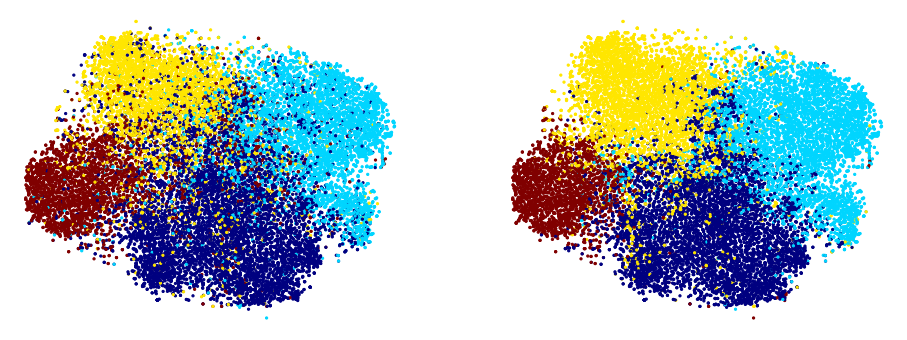

In [113]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, s=5, cmap="jet")
plt.axis("off")
#plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=cluster_df['Cluster'], s=5, cmap="jet")
plt.axis("off")
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px"> AE for ANOMALY DETECTION</div>

# IMPORT LIBRARY

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# IMPORT DATASET

In [2]:
# read the data using pandas dataframe
df = pd.read_csv('Train_Titanic.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EXPLORE/VISUALIZE DATASET

### target variable

In [3]:
Survived    = df[df['Survived']==1]
No_Survived = df[df['Survived']==0]

print("Total =", len(df))

print("Number of customers who Survived =", len(Survived))
print("Percentage bought =", 1.*len(Survived)/len(df)*100.0, "%")
 
print("Did not Survived =", len(No_Survived))
print("Percentage who did not Survived =", 1.*len(No_Survived)/len(df)*100.0, "%")

Total = 891
Number of customers who Survived = 342
Percentage bought = 38.38383838383838 %
Did not Survived = 549
Percentage who did not Survived = 61.61616161616161 %


Text(0.5, 1.0, 'Survived Distribution \n (0: No Survived || 1: Survived)')

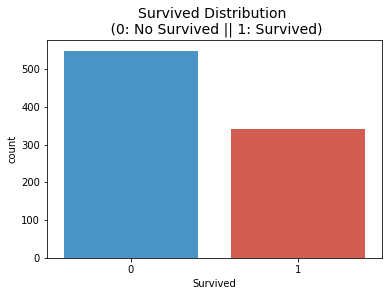

In [4]:
colors = ["#3498db","#e74c3c"]

sns.countplot('Survived', data=df,palette = colors)
plt.title('Survived Distribution \n (0: No Survived || 1: Survived)', fontsize = 14)

# DATA PREPARATION

### Missing data

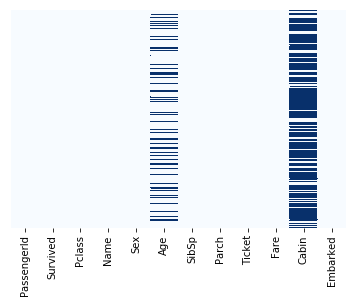

In [5]:
# Let's explore which dataset is missing
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [6]:
org_df = df
removed_features = ['Cabin','Name','Embarked','Ticket','PassengerId']
selected_featues = [e for e in df.columns if e not in removed_features]
selected_featues

['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

In [7]:
df = org_df.loc[:,selected_featues]

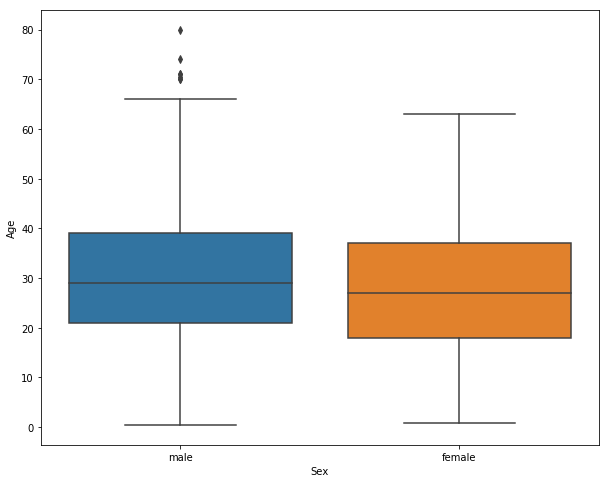

In [8]:
# Let's get the average age for male (~29) and female (~25)
plt.figure(figsize=(10, 8))
sns.boxplot(x='Sex', y='Age',data=df)

In [9]:
def Fill_Age(data):
    age = data[0]
    sex = data[1]

    if pd.isnull(age):
        if sex is 'male': 
            return 29
        else:
            return 25
    else:
        return age

In [10]:
df['Age'] = df[['Age','Sex']].apply(Fill_Age,axis=1)

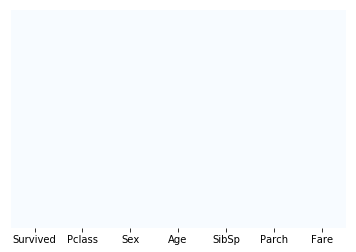

In [11]:
# Let's view the data one more time!
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [13]:
male = pd.get_dummies(df['Sex'], drop_first = True)
# first let's drop the embarked and sex 
df.drop(['Sex'], axis = 1, inplace = True)
# Now let's add the encoded column male again
df = pd.concat([df, male], axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


### Split data into X and y

In [14]:
X = df.drop('Survived',axis=1)
y = df.Survived

### Data Normalization

In [15]:
from sklearn.preprocessing import  StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_scaled = X
X_scaled.Age = scaler.fit_transform(X_scaled.Age.reshape(-1,1))
X_scaled.Fare = scaler.fit_transform(X_scaled.Fare.reshape(-1,1))
X_scaled.Pclass = scaler.fit_transform(X_scaled.Pclass.reshape(-1,1))
X_scaled.head()

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Pclass,Age,SibSp,Parch,Fare,male
0,1.0,0.271174,1,0,0.014151,1
1,0.0,0.472229,1,0,0.139136,0
2,1.0,0.321438,0,0,0.015469,0
3,0.0,0.434531,1,0,0.103644,0
4,1.0,0.434531,0,0,0.015713,1


### Split data into train-test split

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

# AutoEncoder

In [16]:
####### Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
# from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)
#
from IPython.display import display, Math, Latex
import datetime

Using TensorFlow backend.


In [108]:
#set up graphic style in this case I am using the color scheme from xkcd.com
LABELS = ["No Survived","Survived"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

In [17]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


In [59]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state = 101)

X_train = X_train[X_train['Survived'] == 0]
X_train = X_train.drop(['Survived'], axis = 1)
y_test = X_test['Survived']
X_test = X_test.drop(['Survived'], axis = 1)
X_train = X_train.values
X_test = X_test.values
print('Training data size: ', X_train.shape)
print('Validation data size: ', X_test.shape)

Training data size:  (450, 6)
Validation data size:  (179, 6)


In [60]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
X_train_scaled

array([[0.5       , 0.30136986, 0.        , 0.        , 0.04942966,
        1.        ],
       [1.        , 0.32876712, 0.        , 0.        , 0.03094106,
        0.        ],
       [1.        , 0.50684932, 0.        , 0.        , 0.03293726,
        1.        ],
       ...,
       [1.        , 0.32876712, 0.        , 0.        , 0.02908745,
        1.        ],
       [1.        , 0.24657534, 0.        , 0.        , 0.05513308,
        1.        ],
       [1.        , 0.32876712, 1.        , 0.33333333, 0.26444867,
        0.        ]])

In [62]:
# No of Neurons in each Layer [6,4,2,4,6]
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(4), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(2), activation="tanh")(encoder)
# encoder = Dense(int(2), activation="tanh")(encoder)
# decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(4), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 30        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [146]:
# No of Neurons in each Layer [6,3,1,3,6]
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(3), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(1), activation="tanh")(encoder)
# encoder = Dense(int(2), activation="tanh")(encoder)
# decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(3), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 4         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 24        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [184]:
# No of Neurons in each Layer [6,4,1,4,6]
input_dim = X_train.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(4), activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(1), activation="tanh")(encoder)
# encoder = Dense(int(2), activation="tanh")(encoder)
# decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(4), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 30        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________


In [185]:
nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

cp = ModelCheckpoint(filepath="autoencoder1.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

t_ini = datetime.datetime.now()


history = autoencoder.fit(X_train_scaled, X_train_scaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[cp, tb]).history

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history)

Train on 405 samples, validate on 45 samples
Epoch 1/100
405/405 [==============================] - 0s 597us/step - loss: 0.4150 - val_loss: 0.3782
Epoch 2/100
405/405 [==============================] - 0s 27us/step - loss: 0.3781 - val_loss: 0.3436
Epoch 3/100
405/405 [==============================] - 0s 33us/step - loss: 0.3456 - val_loss: 0.3135
Epoch 4/100
405/405 [==============================] - 0s 28us/step - loss: 0.3179 - val_loss: 0.2883
Epoch 5/100
405/405 [==============================] - 0s 26us/step - loss: 0.2947 - val_loss: 0.2677
Epoch 6/100
405/405 [==============================] - 0s 32us/step - loss: 0.2755 - val_loss: 0.2507
Epoch 7/100
405/405 [==============================] - 0s 27us/step - loss: 0.2593 - val_loss: 0.2360
Epoch 8/100
405/405 [==============================] - 0s 32us/step - loss: 0.2452 - val_loss: 0.2230
Epoch 9/100
405/405 [==============================] - 0s 28us/step - loss: 0.2326 - val_loss: 0.2113
Epoch 10/100
405/405 [==============

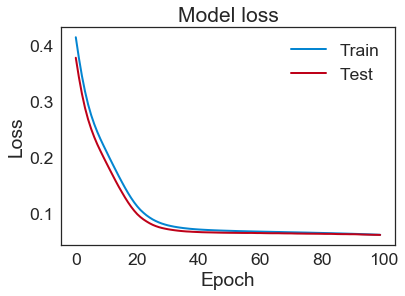

In [186]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [187]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()

,Label,reconstruction_error
count,179.000000,179.000000
mean,0.446927,0.091661
std,0.498570,0.087285
min,0.000000,0.013516
25%,0.000000,0.018328
50%,0.000000,0.069903
75%,1.000000,0.133605
max,1.000000,0.685313


In [188]:
df_error.head()

,Label,reconstruction_error
331,0,0.086201
700,1,0.316518
748,0,0.077284
751,1,0.035841
481,0,0.014166


C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


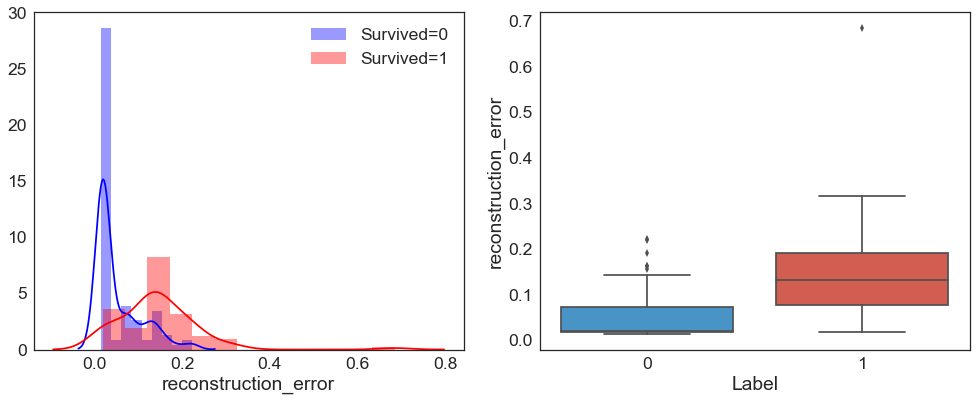

In [189]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 6))
sns.distplot(df_error.loc[df_error.Label==0,'reconstruction_error'],color='blue', ax=ax1, label='Survived=0')
sns.distplot(df_error.loc[df_error.Label==1,'reconstruction_error'],color='red', ax=ax1, label='Survived=1')
ax2 = sns.boxplot(x='Label', y='reconstruction_error', data=df_error, palette=colors)
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [190]:
# change X_tes_scaled to pandas dataframe
numerical_cols = ['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6']
data_n = pd.DataFrame(X_test_scaled, index= y_test.index, columns = numerical_cols)
data_n.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.0,0.609589,0.000,0.000000,0.108365,1.0
700,0.0,0.232877,0.125,0.000000,0.865114,0.0
748,0.0,0.246575,0.125,0.000000,0.201901,1.0
751,1.0,0.068493,0.000,0.166667,0.047433,1.0
481,0.5,0.328767,0.000,0.000000,0.000000,1.0


In [191]:
reconstrcuted_df = autoencoder.predict(data_n)
reconstrcuted_df = pd.DataFrame(reconstrcuted_df, index= data_n.index.values)

In [192]:
reconstrcuted_df.columns = data_n.columns.values
reconstrcuted_df.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.615801,0.336427,0.003936,-0.029446,0.072776,0.752559
700,0.756853,0.397444,0.077654,0.069398,0.089981,0.831449
748,0.594788,0.328915,-0.005524,-0.041984,0.070565,0.740960
751,0.751855,0.394827,0.074653,0.065336,0.089306,0.828587
481,0.674536,0.359186,0.032195,0.008216,0.079438,0.785077


In [193]:
RE_per_dim_df = abs(data_n - reconstrcuted_df)
RE_per_dim_df.head()

,V_1,V_2,V_3,V_4,V_5,V_6
331,0.615801,0.273162,0.003936,0.029446,0.035589,0.247441
700,0.756853,0.164568,0.047346,0.069398,0.775133,0.831449
748,0.594788,0.082339,0.130524,0.041984,0.131337,0.259040
751,0.248145,0.326334,0.074653,0.101331,0.041873,0.171413
481,0.174536,0.030419,0.032195,0.008216,0.079438,0.214923


In [195]:
RE_per_dim_df['Survived'] = y_test
RE_per_dim_df['reconstruction_error'] = df_error['reconstruction_error']
RE_per_dim_df.head(10)

,V_1,V_2,V_3,V_4,V_5,V_6,Survived,reconstruction_error
331,0.615801,0.273162,0.003936,0.029446,0.035589,0.247441,0,0.086201
700,0.756853,0.164568,0.047346,0.069398,0.775133,0.831449,1,0.316518
748,0.594788,0.082339,0.130524,0.041984,0.131337,0.259040,0,0.077284
751,0.248145,0.326334,0.074653,0.101331,0.041873,0.171413,1,0.035841
481,0.174536,0.030419,0.032195,0.008216,0.079438,0.214923,0,0.014166
845,0.234909,0.159780,0.082679,0.076206,0.062393,0.163816,0,0.020681
740,0.579472,0.005157,0.012232,0.050853,0.045061,0.267495,1,0.068689
287,0.249548,0.106429,0.073816,0.064205,0.059095,0.172215,0,0.019387
669,0.680849,0.033050,0.089585,0.012525,0.117520,0.788590,1,0.184752
241,0.213447,0.085307,0.028747,0.094645,0.035107,0.848637,1,0.130673


### ROC Curve Check

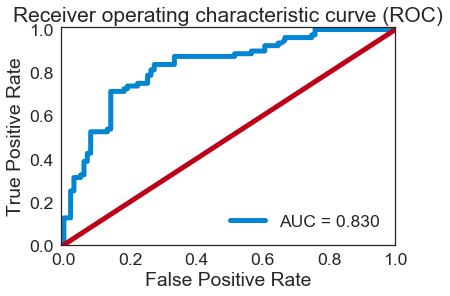

In [196]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(df_error.Label, df_error.reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [197]:
roc_auc

0.8296085858585858

In [198]:
ROC_df = pd.DataFrame()
ROC_df['false_pos_rate'] = false_pos_rate
ROC_df['true_pos_rate'] = true_pos_rate
ROC_df['thresholds'] = thresholds
ROC_df.head(25)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.0000,1.685313
1,0.000000,0.0125,0.685313
2,0.000000,0.1250,0.229567
3,0.020202,0.1250,0.219885
4,0.020202,0.2500,0.195211
5,0.030303,0.2500,0.191521
6,0.030303,0.3125,0.170506
7,0.050505,0.3125,0.162883
8,0.050505,0.3250,0.161851
9,0.060606,0.3250,0.157093


### Recall vs. Precision Thresholding

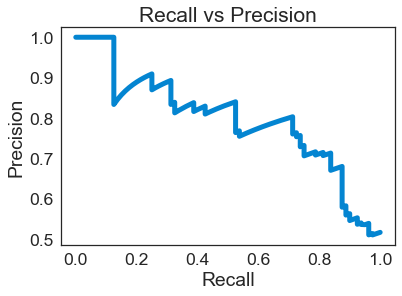

In [199]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(df_error.Label, df_error.reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [200]:
PR_df = pd.DataFrame()
PR_df['precision_rt'] = precision_rt[1:len(threshold_rt)]
PR_df['recall_rt'] = recall_rt[1:len(threshold_rt)]
PR_df['threshold_rt'] = threshold_rt[1:len(threshold_rt)]
PR_df.head(20)

,precision_rt,recall_rt,threshold_rt
0,0.512987,0.9875,0.017554
1,0.509804,0.9750,0.017733
2,0.513158,0.9750,0.017745
3,0.509934,0.9625,0.017747
4,0.513333,0.9625,0.017826
5,0.516779,0.9625,0.017875
6,0.520270,0.9625,0.018032
7,0.527397,0.9625,0.018048
8,0.538462,0.9625,0.018060
9,0.535211,0.9500,0.018062


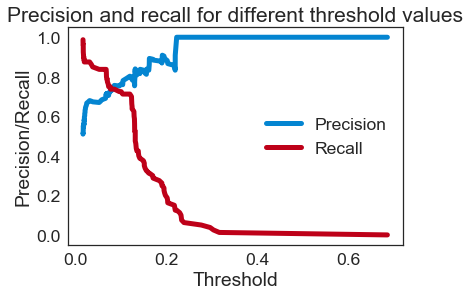

In [201]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Reconstruction Error vs Threshold Check

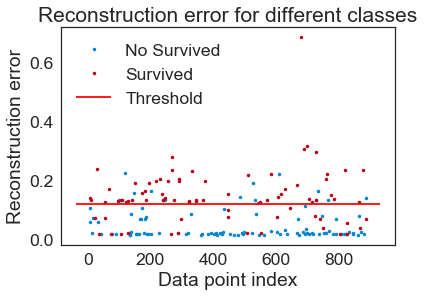

In [205]:
threshold_fixed = 0.12
groups = df_error.groupby('Label')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Survived" if name == 1 else "No Survived")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

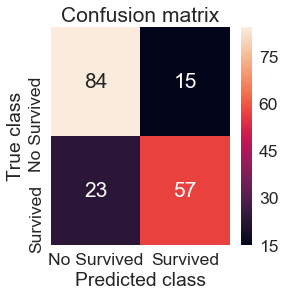

In [206]:
pred_y = [1 if e > threshold_fixed else 0 for e in df_error.reconstruction_error.values]
conf_matrix = confusion_matrix(df_error.Label, pred_y)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [207]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.79      0.71      0.75        80

   micro avg       0.79      0.79      0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

